<a href="https://colab.research.google.com/github/abrahamkoloboe27/python-and-gen-ai-data-science-growup-ai/blob/main/notebooks/s10_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S10 — Embeddings & Moteurs de Recherche Vectorielle (RAG Intro)

## 🎯 Objectifs
- Comprendre les embeddings et leur création
- Maîtriser la recherche de similarité (nearest neighbour)
- Implémenter un index FAISS local
- Évaluer recall et precision du retrieval

## 📋 Contenu
0. Introduction complète aux embeddings
0.2 La recherche vectorielle — concepts et cas d'usage
0.3 Les moteurs de recherche vectorielle — comparaison
1. Installation et Configuration
2. Création du Dataset
3. Génération d'Embeddings
4. Métriques de Similarité (théorie + code)
5. FAISS — théorie approfondie + implémentation
6. Index IVFPQ
7. Évaluation: Recall et Precision
8. Sauvegarde et Chargement
9. Exercices Pratiques
10. Concepts Avancés
11. Guide de Décision

---
# 🧠 Section 0 — Introduction Complète aux Embeddings

> *"Un embedding, c'est l'art de transformer du sens en coordonnées."*

---

## 0.1 Qu'est-ce qu'un Embedding ?

Un **embedding** (plongement vectoriel) est une représentation numérique dense d'un objet — mot, phrase, image, produit — sous forme d'un **vecteur de nombres réels** dans un espace à haute dimension.

### Analogie intuitive 🗺️

Imaginez une carte géographique : chaque ville possède des coordonnées GPS (latitude, longitude). Des villes proches géographiquement ont des coordonnées similaires. Les embeddings font la même chose avec du **sens** :

- `roi` → `[0.82, -0.12, 0.45, ..., 0.33]`  *(384 dimensions)*
- `reine` → `[0.79, -0.08, 0.41, ..., 0.35]`  *(coordonnées proches !)*
- `chien` → `[-0.21, 0.66, -0.18, ..., -0.42]`  *(coordonnées éloignées)*

La magie est que **la proximité dans l'espace vectoriel = la similarité sémantique dans le monde réel**.

### La propriété arithmétique fondamentale

Les embeddings capturent des relations analogiques :

$$\text{roi} - \text{homme} + \text{femme} \approx \text{reine}$$

$$\text{Paris} - \text{France} + \text{Italie} \approx \text{Rome}$$

Cette propriété, découverte avec Word2Vec en 2013, a révolutionné le traitement du langage naturel.

---

## 0.2 Comment sont-ils créés ?

Les embeddings sont appris par des **réseaux de neurones** entraînés sur de grandes quantités de données. Le principe général :

1. **Pré-entraînement** : le modèle apprend à prédire des mots/tokens manquants (tâche auto-supervisée)
2. **Représentation intermédiaire** : les couches cachées du réseau forment naturellement des représentations compactes et riches
3. **Extraction** : on extrait ces représentations intermédiaires — ce sont les embeddings

### Évolution des techniques

| Époque | Technique | Innovation clé |
|--------|-----------|----------------|
| 2013 | **Word2Vec** (Google) | Embeddings de mots, analogies vectorielles |
| 2014 | **GloVe** (Stanford) | Co-occurrence globale des mots |
| 2017 | **FastText** (Facebook) | Sous-mots, gestion des mots rares |
| 2018 | **ELMo** | Embeddings contextuels (BiLSTM) |
| 2018 | **BERT** (Google) | Transformers, contexte bidirectionnel |
| 2019 | **Sentence-BERT** | Embeddings de phrases sémantiques |
| 2022+ | **OpenAI Embeddings** | text-embedding-ada-002, 1536 dims |
| 2023+ | **Multilingual E5, BGE** | Multilingue, performance SOTA |

---

## 0.3 Visualisation conceptuelle de l'espace vectoriel

```
        ^ dimension 2 (ex: "royauté")
        |
  reine *          * roi
        |
        |  * femme          * homme
        |
        +-------------------------> dimension 1 (ex: "genre")
       /
      / dimension 3 (ex: "âge")
```

Dans la réalité, les espaces ont **384, 768 ou 1536 dimensions** — impossible à visualiser directement. On utilise des techniques comme **t-SNE** ou **UMAP** pour réduire à 2D et visualiser.

---

## 0.4 Applications des Embeddings dans l'IA

Les embeddings sont la fondation de nombreuses applications modernes :

### NLP (Traitement du Langage Naturel)
- 🔍 **Recherche sémantique** : trouver des documents par sens, pas par mots-clés
- 💬 **Chatbots & LLMs** : RAG (Retrieval-Augmented Generation)
- 🌐 **Traduction automatique** : espaces multilingues alignés
- 📊 **Classification de texte** : spam, sentiment, catégorisation
- 🔗 **Détection de paraphrase/plagiat**

### Vision par Ordinateur
- 🖼️ **Recherche d'images similaires** (Pinterest, Google Images)
- 👤 **Reconnaissance faciale** (FaceNet)
- 🏷️ **Détection d'objets** (CLIP : texte + image dans le même espace !)

### Systèmes de Recommandation
- 🎬 **Netflix, Spotify** : embeddings d'utilisateurs et de contenus
- 🛍️ **E-commerce** : produits similaires, "les clients ont aussi acheté"
- 📰 **Fils d'actualité personnalisés**

### Autres domaines
- 🧬 **Bio-informatique** : embeddings de protéines (AlphaFold)
- 🎵 **Musique** : similitude de morceaux, génération
- 🔒 **Cybersécurité** : détection d'anomalies comportementales
- 💊 **Médecine** : similarité de molécules, dossiers patients

---

## 0.5 Pourquoi les Embeddings sont Révolutionnaires

### Avant les embeddings : représentation one-hot

```
vocabulaire = ["chat", "chien", "voiture", "avion"]
"chat"    → [1, 0, 0, 0]
"chien"   → [0, 1, 0, 0]
"voiture" → [0, 0, 1, 0]
```

**Problèmes** :
- Aucune information sémantique (chat et chien aussi distants que chat et voiture)
- Dimension = taille du vocabulaire (100k+) → très sparse
- Ne gère pas les nouveaux mots

### Avec les embeddings : représentation dense

```
"chat"    → [0.82, 0.45, -0.12, ..., 0.33]  (384 dims, dense)
"chien"   → [0.79, 0.41, -0.08, ..., 0.35]  (très similaire !)
"voiture" → [-0.21, -0.18, 0.66, ..., -0.42] (très différent)
```

**Avantages** :
- ✅ Similarité sémantique encodée géométriquement
- ✅ Dimension fixe et compacte (pas d'explosion)
- ✅ Généralisation sur des données jamais vues
- ✅ Transfert d'apprentissage possible (fine-tuning)

---

## 0.6 Tableau Récapitulatif — Modèles d'Embeddings

| Modèle | Dimensions | Multilingue | Open Source | Cas d'usage principal |
|--------|-----------|-------------|-------------|----------------------|
| **Word2Vec** | 50-300 | ❌ | ✅ | Embeddings de mots, baseline |
| **GloVe** | 50-300 | ❌ | ✅ | NLP classique, analogies |
| **FastText** | 300 | ✅ partiel | ✅ | Textes courts, mots rares |
| **BERT** | 768 | ❌ (mBERT oui) | ✅ | Classification, NER |
| **Sentence-BERT** | 384-768 | ✅ | ✅ | Similarité de phrases |
| **text-embedding-ada-002** | 1536 | ✅ | ❌ (OpenAI) | Usage général, RAG |
| **text-embedding-3-small** | 1536 | ✅ | ❌ (OpenAI) | Efficace, moins cher |
| **text-embedding-3-large** | 3072 | ✅ | ❌ (OpenAI) | Haute performance |
| **E5-large** | 1024 | ✅ | ✅ | SOTA open source |
| **BGE-M3** | 1024 | ✅ | ✅ | Multilingue SOTA |
| **paraphrase-multilingual** | 384 | ✅ (50+ langues) | ✅ | Ce notebook ! |

---

## 0.7 Notion de Dimension

La **dimension** d'un embedding représente le nombre de coordonnées dans l'espace vectoriel.

- **Plus de dimensions** → Plus d'information potentielle → Meilleure précision
- **Moins de dimensions** → Plus rapide à comparer → Moins de mémoire
- **Compromis typique** : 384-1536 dimensions pour la plupart des applications

Un embedding de 384 dimensions = un point dans un espace à 384 dimensions = un vecteur de 384 nombres flottants = **384 × 4 bytes = ~1.5 Ko par vecteur**. Un million de documents = ~1.5 Go de vecteurs.

---
# 🔍 Section 0.2 — La Recherche Vectorielle

## Qu'est-ce que la Recherche Vectorielle ?

La **recherche vectorielle** (vector search, similarity search) est une technique permettant de trouver les éléments les plus similaires à une requête dans une base de vecteurs, en mesurant leur **proximité géométrique** dans l'espace vectoriel.

Contrairement à la recherche traditionnelle par mots-clés (Elasticsearch, SQL LIKE), la recherche vectorielle comprend le **sens** des requêtes.

---

## Pourquoi la Recherche Traditionnelle Échoue

### Exemple concret

Requête : *"Comment soigner un rhume ?"*

**Recherche par mots-clés** :
- ✅ Trouve : "Remèdes contre le rhume"
- ✅ Trouve : "Comment guérir d'un rhume ?"
- ❌ Rate : "Traitement des infections respiratoires légères"
- ❌ Rate : "Que faire quand on est enrhumé ?"
- ❌ Rate : "Antibiotiques vs repos pour les maladies virales"

**Recherche vectorielle** :
- ✅ Trouve tous les exemples ci-dessus !
- ✅ Comprend la relation sémantique entre rhume / infection / viral
- ✅ Fonctionne même si aucun mot de la requête n'est dans le document

---

## Comment Fonctionne la Recherche Vectorielle

### Étape 1 : Indexation (offline)

```
Document → [Modèle d'embedding] → Vecteur → [Index vectoriel]
"Le chat mange" → BERT → [0.82, -0.12, ..., 0.45] → stocké
```

### Étape 2 : Requête (online)

```
Requête → [Modèle d'embedding] → Vecteur requête
"animal qui mange" → BERT → [0.79, -0.10, ..., 0.43]
```

### Étape 3 : Comparaison

Calculer la distance/similarité entre le vecteur requête et **tous les vecteurs indexés**, puis retourner les k plus proches (k-NN : k Nearest Neighbors).

---

## Nearest Neighbor Search : Exact vs Approché

### Exact Nearest Neighbor (kNN)
- Compare la requête avec **TOUS** les vecteurs
- Garantit de trouver les vrais k plus proches voisins
- Complexité : $O(n \cdot d)$ où n = nb vecteurs, d = dimensions
- **Problème** : Pour 10 millions de vecteurs de 768 dims → des milliards d'opérations !

### Approximate Nearest Neighbor (ANN) ⚡
- Utilise des structures d'index intelligentes pour éviter de tout parcourir
- Peut manquer quelques voisins vrais, mais très rare en pratique
- Complexité : $O(\log n)$ à $O(\sqrt{n})$ selon la méthode
- **Gain typique** : 10x à 1000x plus rapide pour >0.95 de recall
- C'est ce qu'utilisent FAISS (IVF, HNSW), Milvus, Qdrant, etc.

---

## Le Compromis Fondamental : Vitesse vs Précision (Recall)

```
Précision (Recall)
100% |●  Exact kNN
     |  \
 99% |   ● HNSW (ef=200)
     |    \
 95% |     ● HNSW (ef=100)
     |      \
 90% |       ● IVF (nprobe=10)
     |        \
 80% |         ● IVF (nprobe=5)
     +----------------------------> Vitesse (req/sec)
       lent          très rapide
```

Dans la plupart des applications réelles, **95-99% de recall avec 10-100x de speedup** est un excellent compromis.

---

## Cas d'Usage de la Recherche Vectorielle

| Domaine | Application | Exemple concret |
|---------|-------------|-----------------|
| 🔍 **RAG / LLMs** | Retrieval-Augmented Generation | ChatGPT avec contexte entreprise |
| 📚 **Recherche sémantique** | Moteur de recherche interne | Trouver des docs RH par sens |
| 🎬 **Recommandation** | Contenus similaires | Netflix "parce que vous avez aimé..." |
| 🖼️ **Recherche d'images** | Image-to-image | Pinterest visuellement similaire |
| 🔒 **Détection de fraude** | Anomalie comportementale | Transaction inhabituelle |
| 🧬 **Bio-informatique** | Séquences similaires | Protéines homologues |
| 💬 **Déduplication** | Documents en double | Articles de presse dupliqués |
| 🌐 **Traduction** | Alignement multilingue | Phrases équivalentes EN/FR |
| 💊 **Pharma** | Molécules similaires | Drug discovery |
| 🛡️ **Cybersécurité** | Malwares similaires | Variantes de virus |

---

## Architecture Typique d'un Système RAG avec Recherche Vectorielle

```
OFFLINE (Indexation)                    ONLINE (Requête)
━━━━━━━━━━━━━━━━━━━━━                   ━━━━━━━━━━━━━━━━━━━━━━━━━

Documents          Query utilisateur
    ↓                   ↓
[Chunking]         [Embedding model]
    ↓                   ↓
[Embedding model]  Vecteur requête
    ↓                   ↓
[Index vectoriel]  [Recherche ANN]  →  Top-k documents
                        ↓
                   [LLM (GPT-4...)]
                        ↓
                   Réponse enrichie
```

---

## Métriques de Performance en Recherche Vectorielle

| Métrique | Définition | Formule | Interprétation |
|----------|-----------|---------|----------------|
| **Recall@k** | % de vrais pertinents dans les k résultats | $\frac{|Pertinents \cap Récupérés@k|}{|Pertinents|}$ | 1.0 = parfait |
| **Precision@k** | % des k résultats qui sont pertinents | $\frac{|Pertinents \cap Récupérés@k|}{k}$ | 1.0 = parfait |
| **MRR** | Position moyenne du 1er résultat pertinent | $\frac{1}{|Q|}\sum_{i=1}^{|Q|}\frac{1}{rank_i}$ | 1.0 = toujours 1er |
| **NDCG@k** | Normalise selon la position du résultat | Complexe | Tient compte de l'ordre |
| **Latence p99** | 99e percentile du temps de réponse | - | <100ms typiquement |
| **QPS** | Queries Per Second (débit) | - | Selon l'infrastructure |

---
# 🏭 Section 0.3 — Les Moteurs de Recherche Vectorielle

## Qu'est-ce qu'un Moteur de Recherche Vectorielle ?

Un **moteur de recherche vectorielle** (vector search engine ou vector database) est un système spécialisé pour :
1. **Stocker** des vecteurs (embeddings) de manière persistante et scalable
2. **Indexer** ces vecteurs avec des structures ANN efficaces
3. **Rechercher** les k plus proches voisins d'une requête vectorielle, très rapidement
4. **Filtrer** par métadonnées (ex: chercher dans les docs d'une seule entreprise)
5. **Gérer** la mise à jour, la suppression, la réplication des données

Un simple tableau NumPy suffit pour 1000 vecteurs. Pour 100 millions, il faut un vrai moteur.

---

## Comparaison Complète des Moteurs de Recherche Vectorielle

| Moteur | Type | Langage | Scalabilité | Filtrage | Prix | Cas d'usage idéal |
|--------|------|---------|-------------|----------|------|-------------------|
| **FAISS** | Local (lib) | C++/Python | Mono-nœud | ❌ natif | Gratuit | Recherche locale, prototypage, recherche académique |
| **Milvus** | Open source / Cloud | Go/C++ | Multi-nœuds ✅ | ✅ | Gratuit (self-hosted) / Zilliz Cloud | Production large échelle, milliards de vecteurs |
| **Weaviate** | Open source / Cloud | Go | Multi-nœuds ✅ | ✅ | Gratuit / Cloud payant | Recherche hybride (vectorielle + BM25), GraphQL |
| **Pinecone** | Cloud managed | - | Auto-scale ✅ | ✅ | Gratuit jusqu'à 1M / Payant | Rapidité de déploiement, serverless, startup |
| **Qdrant** | Open source / Cloud | Rust | Multi-nœuds ✅ | ✅ avancé | Gratuit / Cloud payant | Haute performance, filtrage complexe |
| **Chroma** | Local / Cloud | Python | Mono-nœud | ✅ | Gratuit | Prototypage rapide, RAG avec LangChain |
| **Redis Vector** | Hybrid | C | Horizontal ✅ | ✅ | Redis open source / Enterprise | Cas temps réel, déjà utilisateurs Redis |
| **Elasticsearch** | Hybrid | Java | Horizontal ✅ | ✅ | Open source / Elastic Cloud | Recherche hybride (lexicale + vectorielle) |
| **pgvector** | Extension SQL | C | Mono-nœud | ✅ SQL | Gratuit | Déjà sur PostgreSQL, petits volumes |
| **Vespa** | Open source | Java/C++ | Multi-nœuds ✅ | ✅ | Gratuit / Managed | Recherche complexe + ML en temps réel |

---

## Comparaison Technique Approfondie

| Moteur | Index ANN | Distance supportée | Persistance | API |
|--------|-----------|-------------------|-------------|-----|
| **FAISS** | Flat, IVF, HNSW, PQ | L2, IP, Cosine | Fichier binaire | Python/C++ |
| **Milvus** | IVF_FLAT, HNSW, IVF_PQ, SCANN | L2, IP, Cosine, Jaccard | Distributed storage | gRPC / REST |
| **Weaviate** | HNSW | Cosine, L2, Dot | Disk persistent | GraphQL / REST |
| **Pinecone** | Propriétaire (Pinecone Graph) | Cosine, Dot, Euclidean | Cloud managed | REST / gRPC |
| **Qdrant** | HNSW | Cosine, Dot, L2, Manhattan | Disk + WAL | REST / gRPC |
| **Chroma** | HNSW (via hnswlib) | L2, Cosine, IP | SQLite / Parquet | Python / REST |
| **Redis Vector** | FLAT, HNSW | L2, IP, Cosine | RDB / AOF | Redis protocol |
| **Elasticsearch** | HNSW | Cosine, Dot, L2 | Lucene segments | REST |

---

## Quand Choisir Quel Moteur ?

### 🧪 Pour du prototypage et de la R&D
→ **FAISS** ou **Chroma** : simple, rapide à mettre en place, pas de serveur

### 🏭 Pour la production petite/moyenne échelle (<10M vecteurs)
→ **Qdrant** ou **Weaviate** : excellent équilibre performance/fonctionnalités, Docker-ready

### 🚀 Pour la production grande échelle (>100M vecteurs)
→ **Milvus** : conçu pour ça, très scalable

### ⚡ Pour le temps réel ou déjà sur Redis
→ **Redis Vector Search** : faible latence, intégration transparente

### 🌐 Pour la recherche hybride (textuelle + vectorielle)
→ **Elasticsearch** avec kNN ou **Weaviate** avec BM25 hybrid

### 💰 Pour une startup qui veut déployer vite sans gérer l'infra
→ **Pinecone** : serverless, zéro gestion

### 🗄️ Pour des équipes déjà sur PostgreSQL
→ **pgvector** : extension PostgreSQL native, SQL familier

---

## Architecture de Déploiement Typique

```
Application
    ↓  requête texte
[Modèle d'embedding]   ← GPU/CPU server
    ↓  vecteur 768-dim
[Moteur vectoriel]     ← Qdrant / Milvus / Pinecone
    ↓  top-k vecteurs + métadonnées
[Application]
    ↓  documents récupérés
[LLM]                  ← OpenAI / Llama / Mistral
    ↓  réponse finale
Utilisateur
```

---

## Points de Vigilance en Production

| Aspect | Recommandation |
|--------|----------------|
| **Cohérence** | Même modèle d'embedding pour indexation et requête ! |
| **Versioning** | Gérer les changements de modèle (réindexation complète) |
| **Monitoring** | Surveiller la latence, le recall, la dérive des distributions |
| **Sécurité** | Isolation par tenant, chiffrement des vecteurs sensibles |
| **Backup** | Les index ANN peuvent être reconstruits mais c'est long |
| **Mise à jour** | Ajout de vecteurs = facile ; suppression = selon le moteur |

---
## 1. Installation et Configuration

In [1]:
# Installation des dépendances
! pip install faiss-cpu openai sentence-transformers pandas numpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 59.6 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import faiss
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from typing import List, Tuple
import pickle

print("✅ Bibliothèques importées")

✅ Bibliothèques importées


## 2. Création du Dataset

Nous allons créer un dataset simulé de documents techniques pour la démonstration.

In [3]:
# Dataset de documents (simulé)
documents = [
    {"id": 1, "text": "Le machine learning est une branche de l'intelligence artificielle.", "category": "ML"},
    {"id": 2, "text": "Les réseaux de neurones profonds sont utilisés pour l'apprentissage profond.", "category": "DL"},
    {"id": 3, "text": "Python est un langage de programmation populaire pour la data science.", "category": "Programming"},
    {"id": 4, "text": "FastAPI permet de créer des APIs REST rapidement avec Python.", "category": "Programming"},
    {"id": 5, "text": "Les transformers révolutionnent le traitement du langage naturel.", "category": "NLP"},
    {"id": 6, "text": "BERT est un modèle pré-entraîné basé sur l'architecture transformer.", "category": "NLP"},
    {"id": 7, "text": "Le gradient descent est un algorithme d'optimisation fondamental.", "category": "ML"},
    {"id": 8, "text": "Les embeddings capturent la sémantique des mots dans un espace vectoriel.", "category": "NLP"},
    {"id": 9, "text": "Docker permet de conteneuriser des applications pour un déploiement facile.", "category": "DevOps"},
    {"id": 10, "text": "Kubernetes orchestre des conteneurs à grande échelle.", "category": "DevOps"},
    {"id": 11, "text": "Les CNNs sont particulièrement efficaces pour la vision par ordinateur.", "category": "DL"},
    {"id": 12, "text": "Le fine-tuning adapte un modèle pré-entraîné à une tâche spécifique.", "category": "ML"},
    {"id": 13, "text": "GPT-4 est un modèle de langage génératif développé par OpenAI.", "category": "NLP"},
    {"id": 14, "text": "Les API REST utilisent HTTP pour communiquer entre services.", "category": "Programming"},
    {"id": 15, "text": "L'attention est le mécanisme clé des architectures transformer.", "category": "DL"},
    {"id": 16, "text": "Pandas est une bibliothèque Python pour l'analyse de données.", "category": "Programming"},
    {"id": 17, "text": "Le RAG combine retrieval et génération pour améliorer les LLMs.", "category": "NLP"},
    {"id": 18, "text": "FAISS est une bibliothèque pour la recherche de similarité vectorielle.", "category": "ML"},
    {"id": 19, "text": "Les bases de données vectorielles stockent et recherchent des embeddings.", "category": "ML"},
    {"id": 20, "text": "Le tokenisation découpe le texte en unités traitables par les modèles.", "category": "NLP"},
]

df = pd.DataFrame(documents)
print(f"📊 Dataset créé: {len(df)} documents")
print(df.head())

📊 Dataset créé: 20 documents
   id                                               text     category
0   1  Le machine learning est une branche de l'intel...           ML
1   2  Les réseaux de neurones profonds sont utilisés...           DL
2   3  Python est un langage de programmation populai...  Programming
3   4  FastAPI permet de créer des APIs REST rapideme...  Programming
4   5  Les transformers révolutionnent le traitement ...          NLP


## 3. Génération d'Embeddings

### 3.1 Chargement du modèle d'embeddings

In [4]:
# Charger un modèle d'embeddings multilingue
# Options: 'paraphrase-multilingual-MiniLM-L12-v2', 'distiluse-base-multilingual-cased-v2'
embedding_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

print(f"✅ Modèle chargé: {embedding_model.get_sentence_embedding_dimension()} dimensions")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/526 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Modèle chargé: 384 dimensions


### 3.2 Création des embeddings

In [5]:
def create_embeddings(texts: List[str], model: SentenceTransformer) -> np.ndarray:
    """
    Créer des embeddings pour une liste de textes
    """
    embeddings = model.encode(texts, show_progress_bar=True)
    return np.array(embeddings).astype('float32')

# Générer les embeddings
texts = df['text'].tolist()
embeddings = create_embeddings(texts, embedding_model)

print(f"✅ Embeddings créés: shape = {embeddings.shape}")
print(f"   - {embeddings.shape[0]} documents")
print(f"   - {embeddings.shape[1]} dimensions")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Embeddings créés: shape = (20, 384)
   - 20 documents
   - 384 dimensions


---
# 📐 Section 4 — Métriques de Similarité : Théorie Approfondie

Avant de coder, comprenons les métriques de distance et de similarité qui sont au cœur de la recherche vectorielle. Le **choix de la métrique est crucial** et dépend du type de données, du modèle d'embedding utilisé, et du cas d'usage.

---

## 4.1 Similarité Cosinus (Cosine Similarity)

### Définition

La similarité cosinus mesure le **cosinus de l'angle** entre deux vecteurs, indépendamment de leur magnitude (longueur). Elle varie entre **-1 et +1** (ou 0 et 1 pour des vecteurs positifs).

$$\text{cos}(\vec{A}, \vec{B}) = \frac{\vec{A} \cdot \vec{B}}{\|\vec{A}\| \cdot \|\vec{B}\|}$$

où $\vec{A} \cdot \vec{B} = \sum_{i=1}^{n} A_i B_i$ est le produit scalaire.

### Interprétation

| Valeur | Signification |
|--------|--------------|
| **1.0** | Vecteurs identiques (même direction) |
| **0.0** | Vecteurs perpendiculaires (aucune relation) |
| **-1.0** | Vecteurs opposés |

### Quand utiliser la similarité cosinus ?

✅ **Idéale pour** :
- Embeddings de texte en général (la magnitude peut varier selon la longueur du texte)
- Comparaison de documents de longueurs différentes
- Modèles Sentence-BERT, Word2Vec, GloVe

⚠️ **Limitations** :
- Ignore la magnitude (un texte de 1 mot et 1000 mots avec le même thème = même score)
- Coût calcul $O(d)$ par paire

---

## 4.2 Distance Euclidienne (L2)

### Définition

La distance euclidienne (ou norme L2) mesure la **distance en ligne droite** dans l'espace à n dimensions. C'est l'extension de la formule de Pythagore.

$$d_{L2}(\vec{A}, \vec{B}) = \|\vec{A} - \vec{B}\|_2 = \sqrt{\sum_{i=1}^{n} (A_i - B_i)^2}$$

### Propriétés

- Distance de 0 = vecteurs identiques
- Plus la distance est grande, moins les vecteurs sont similaires
- **Sensible à la magnitude** des vecteurs

### Quand utiliser L2 ?

✅ **Idéale pour** :
- Vecteurs normalisés (alors L2 ∝ cosine)
- Images et données continues où la magnitude a du sens
- Clustering (k-means utilise L2)
- FAISS par défaut utilise L2

⚠️ **Limitations** :
- Sensible à l'échelle des features (normalisation recommandée)
- **Malédiction de la dimensionnalité** : en haute dimension, toutes les distances tendent à devenir similaires

> **Note** : Si les vecteurs sont normalisés (norme = 1), alors : $d_{L2}^2 = 2(1 - \cos(\vec{A}, \vec{B}))$  
> i.e. minimiser L2 = maximiser cosine sur des vecteurs unitaires.

---

## 4.3 Produit Scalaire / Inner Product (IP)

### Définition

Le produit scalaire mesure à la fois l'**angle** ET la **magnitude** des vecteurs.

$$\text{IP}(\vec{A}, \vec{B}) = \vec{A} \cdot \vec{B} = \sum_{i=1}^{n} A_i B_i = \|\vec{A}\| \cdot \|\vec{B}\| \cdot \cos(\theta)$$

### Quand utiliser IP ?

✅ **Idéal pour** :
- Modèles entraînés explicitement pour le produit scalaire (OpenAI text-embedding-ada-002)
- Systèmes de recommandation (magnitude = popularité ou confiance)
- Quand la magnitude du vecteur encode une information utile

⚠️ **Limitations** :
- Résultats non bornés → moins intuitif
- Si les vecteurs ne sont pas normalisés, favorise les vecteurs de grande magnitude

> **Conseil** : Vérifiez toujours la documentation du modèle d'embedding pour savoir quelle métrique il préconise !

---

## 4.4 Distance Manhattan (L1)

### Définition

La distance Manhattan (taxicab distance) mesure la somme des **valeurs absolues des différences** composante par composante. Imagine te déplacer dans une grille de rues comme à Manhattan.

$$d_{L1}(\vec{A}, \vec{B}) = \|\vec{A} - \vec{B}\|_1 = \sum_{i=1}^{n} |A_i - B_i|$$

### Quand utiliser L1 ?

✅ **Idéale pour** :
- Données avec des **outliers** (plus robuste que L2)
- Données sparse (beaucoup de zéros)
- Features catégorielles encodées numériquement

⚠️ **Limitations** :
- Moins populaire pour les embeddings
- Pas supportée nativement par tous les moteurs vectoriels

---

## 4.5 Distance de Hamming

### Définition

La distance de Hamming compte le nombre de **positions différentes** entre deux vecteurs binaires ou deux chaînes de même longueur.

$$d_{Ham}(\vec{A}, \vec{B}) = \sum_{i=1}^{n} \mathbb{1}[A_i \neq B_i]$$

### Quand utiliser Hamming ?

✅ **Idéale pour** :
- **Embeddings binaires** (compact, très rapide à comparer via XOR)
- Codes de correction d'erreurs
- Comparaison de séquences ADN
- Hashing perceptuel d'images

⚠️ **Limitations** :
- Seulement applicable à des vecteurs binaires ou discrets
- Perd les nuances des valeurs continues

---

## 4.6 Distance de Jaccard

### Définition

Mesure la similarité entre deux **ensembles** (sets).

$$J(A, B) = \frac{|A \cap B|}{|A \cup B|}$$

Varie entre 0 (aucune intersection) et 1 (ensembles identiques).

### Quand utiliser Jaccard ?

✅ **Idéale pour** :
- Comparaison de documents par ensembles de mots (bag-of-words)
- Détection de plagiat
- Recommandation basée sur des achats communs

---

## 4.7 Tableau Comparatif Complet des Métriques

| Métrique | Formule | Plage | Normalisation req. | Robuste aux outliers | Haute dimension | Cas d'usage |
|----------|---------|-------|-------------------|---------------------|-----------------|-------------|
| **Cosine** | $\frac{\vec{A}\cdot\vec{B}}{\|A\|\|B\|}$ | [-1, 1] | ❌ non req. | Moyen | ✅ Très bon | NLP, texte, Sentence-BERT |
| **L2 (Euclidean)** | $\sqrt{\sum(A_i-B_i)^2}$ | [0, +∞) | ✅ recommandée | ❌ Sensible | ⚠️ Moyen | Images, données continues |
| **Inner Product** | $\sum A_i B_i$ | (-∞, +∞) | ❌ non req. | ❌ Sensible | ✅ Bon | OpenAI embeddings, recommandation |
| **L1 (Manhattan)** | $\sum|A_i-B_i|$ | [0, +∞) | ✅ recommandée | ✅ Bon | ⚠️ Moyen | Données sparse, robustesse |
| **Hamming** | $\sum \mathbb{1}[A_i\neq B_i]$ | [0, d] | N/A (binaire) | N/A | ✅ Excellent | Binaire, ADN, hashing |
| **Jaccard** | $\frac{|A∩B|}{|A∪B|}$ | [0, 1] | N/A (ensembles) | N/A | ❌ Mauvais | Sets, NLP bag-of-words |

---

## 4.8 Métriques vs Modèles d'Embedding

| Modèle | Métrique recommandée | Raison |
|--------|---------------------|--------|
| **Sentence-BERT** | Cosine | Entraîné avec cosine |
| **paraphrase-multilingual** | Cosine | Embeddings normalisés |
| **text-embedding-ada-002 (OpenAI)** | Cosine ou Inner Product | Vecteurs normalisés |
| **Word2Vec / GloVe** | Cosine | Standard pour word embeddings |
| **CLIP (images+texte)** | Cosine | Espace normalisé partagé |
| **ANN Binary Codes** | Hamming | XOR bit-à-bit très rapide |
| **Collaborative Filtering** | Inner Product | Magnitude = confiance |

## 4. Métriques de Similarité

### 4.1 Cosine Similarity

In [6]:
def compute_cosine_similarity(embedding1: np.ndarray, embedding2: np.ndarray) -> float:
    """
    Calculer la similarité cosinus entre deux embeddings
    """
    return cosine_similarity([embedding1], [embedding2])[0][0]

# Exemple: Comparer deux documents
doc1_emb = embeddings[0]  # "Le machine learning..."
doc2_emb = embeddings[1]  # "Les réseaux de neurones..."
doc3_emb = embeddings[2]  # "Python est un langage..."

sim_1_2 = compute_cosine_similarity(doc1_emb, doc2_emb)
sim_1_3 = compute_cosine_similarity(doc1_emb, doc3_emb)

print(f"Similarité entre doc1 et doc2 (tous deux ML): {sim_1_2:.4f}")
print(f"Similarité entre doc1 et doc3 (ML vs Programming): {sim_1_3:.4f}")

Similarité entre doc1 et doc2 (tous deux ML): 0.4438
Similarité entre doc1 et doc3 (ML vs Programming): 0.2155


### 4.2 Matrice de similarité

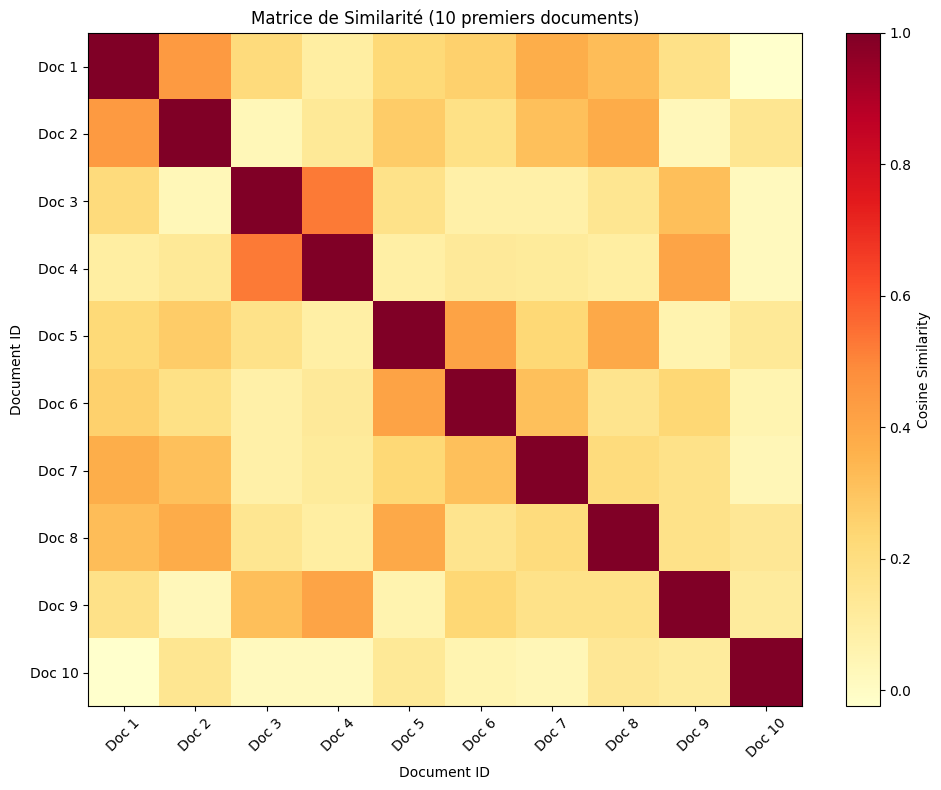

In [7]:
# Calculer la matrice de similarité pour les 10 premiers documents
sample_embeddings = embeddings[:10]
similarity_matrix = cosine_similarity(sample_embeddings)

# Visualiser
plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap='YlOrRd', aspect='auto')
plt.colorbar(label='Cosine Similarity')
plt.xlabel('Document ID')
plt.ylabel('Document ID')
plt.title('Matrice de Similarité (10 premiers documents)')
plt.xticks(range(10), [f"Doc {i+1}" for i in range(10)], rotation=45)
plt.yticks(range(10), [f"Doc {i+1}" for i in range(10)])
plt.tight_layout()
plt.show()

### 4.3 Démonstration Comparative des Métriques de Distance

Comparons visuellement les différentes métriques sur nos embeddings réels.

In [8]:
# =====================================================
# Démonstration comparative des métriques de distance
# =====================================================
from scipy.spatial.distance import euclidean, cityblock, hamming

def compute_all_metrics(vec_a: np.ndarray, vec_b: np.ndarray) -> dict:
    """Calcule toutes les métriques de distance/similarité entre deux vecteurs"""
    # Normaliser pour cosine
    norm_a_val = np.linalg.norm(vec_a)
    norm_b_val = np.linalg.norm(vec_b)
    if norm_a_val < 1e-9 or norm_b_val < 1e-9:
        import warnings
        warnings.warn("Vecteur quasi-nul détecté — embedding potentiellement invalide")
    norm_a = vec_a / (norm_a_val + 1e-9)
    norm_b = vec_b / (norm_b_val + 1e-9)

    cosine_sim = float(np.dot(norm_a, norm_b))
    l2_dist = float(euclidean(vec_a, vec_b))
    l1_dist = float(cityblock(vec_a, vec_b))
    dot_product = float(np.dot(vec_a, vec_b))

    return {
        "Cosine Similarity": cosine_sim,
        "L2 Distance": l2_dist,
        "L1 Distance": l1_dist,
        "Inner Product": dot_product,
    }

# Paires de documents à comparer
pairs = [
    (0, 1, "ML vs Deep Learning (domaine proche)"),
    (0, 2, "ML vs Python/Programming (domaine éloigné)"),
    (4, 5, "Transformers vs BERT (très similaires)"),
    (8, 9, "Docker vs Kubernetes (même domaine DevOps)"),
    (0, 16, "ML vs RAG (lien indirect via NLP)"),
]

print(f"{'Paire':<45} {'Cosine':>8} {'L2':>8} {'L1':>10} {'Dot':>10}")
print("=" * 85)

results_list = []
for i, j, label in pairs:
    metrics = compute_all_metrics(embeddings[i], embeddings[j])
    results_list.append((label, metrics))
    print(f"{label:<45} {metrics['Cosine Similarity']:>8.4f} {metrics['L2 Distance']:>8.4f} "
          f"{metrics['L1 Distance']:>10.2f} {metrics['Inner Product']:>10.4f}")

print()
print("✅ Observation: Cosine et Inner Product montrent des tendances similaires")
print("   (car les embeddings Sentence-BERT sont quasi-normalisés)")

Paire                                           Cosine       L2         L1        Dot
ML vs Deep Learning (domaine proche)            0.4438   4.8742      76.87     9.2364
ML vs Python/Programming (domaine éloigné)      0.2155   5.6315      87.85     4.3075
Transformers vs BERT (très similaires)          0.4112   4.4368      68.87     6.8748
Docker vs Kubernetes (même domaine DevOps)      0.1144   4.8540      76.78     1.5185
ML vs RAG (lien indirect via NLP)               0.1980   4.9712      77.26     3.0126

✅ Observation: Cosine et Inner Product montrent des tendances similaires
   (car les embeddings Sentence-BERT sont quasi-normalisés)


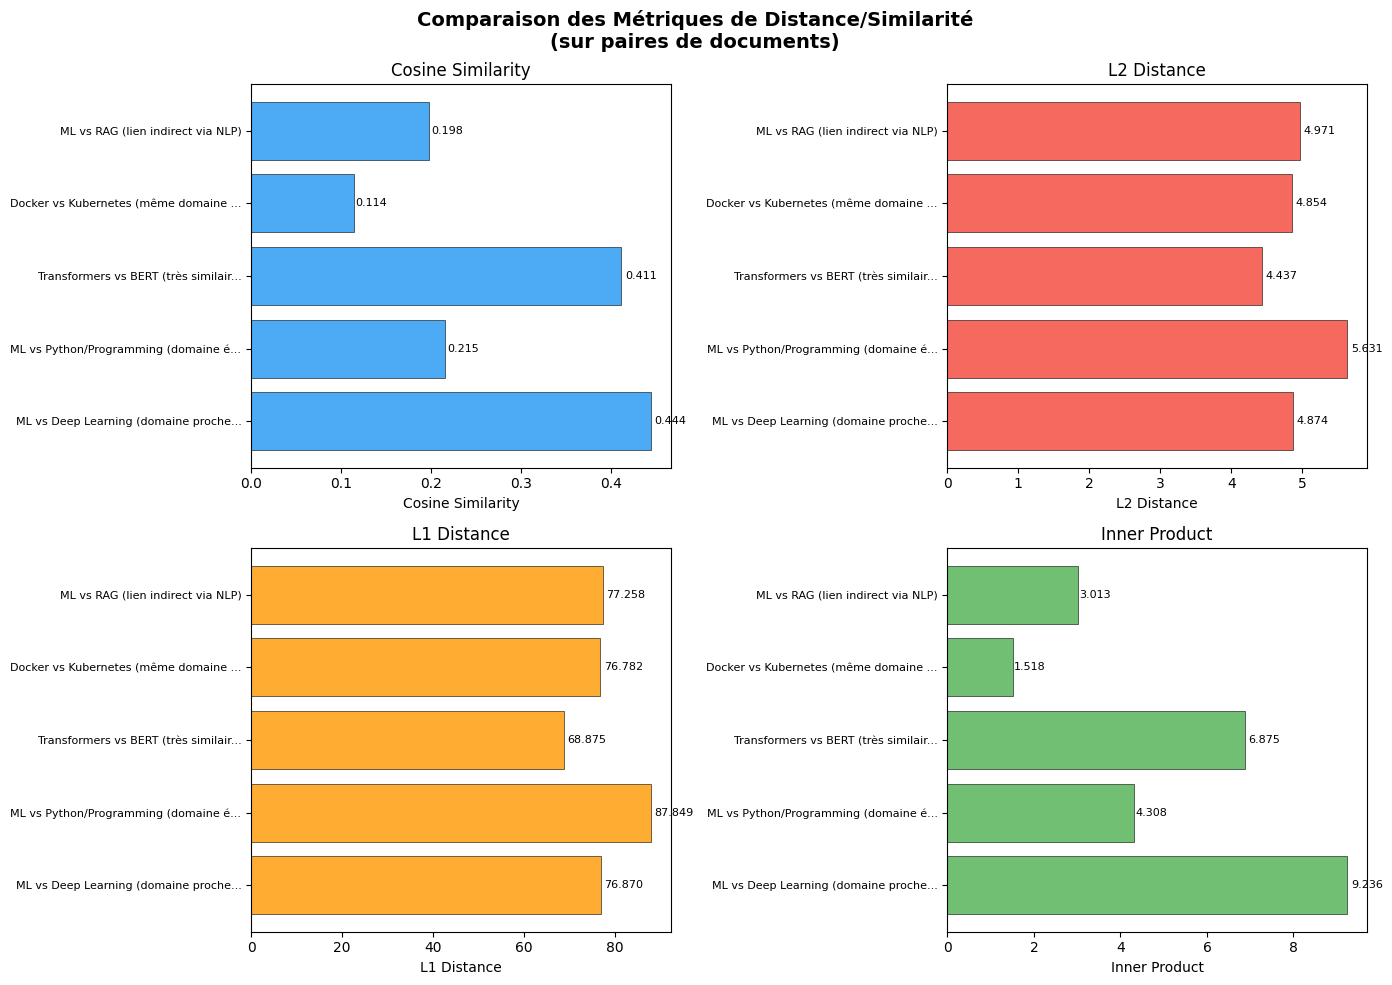


💡 Notes d'interprétation:
  - Cosine Similarity : plus proche de 1 = plus similaire
  - L2 Distance       : plus proche de 0 = plus similaire
  - L1 Distance       : plus proche de 0 = plus similaire
  - Inner Product     : plus grand = plus similaire


In [9]:
# Visualisation comparative des métriques
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparaison des Métriques de Distance/Similarité\n(sur paires de documents)',
             fontsize=14, fontweight='bold')

MAX_LABEL_LENGTH = 35  # Longueur max des étiquettes pour l'affichage
labels = [p[2][:MAX_LABEL_LENGTH] + '...' if len(p[2]) > MAX_LABEL_LENGTH else p[2] for p in pairs]
metric_names = ["Cosine Similarity", "L2 Distance", "L1 Distance", "Inner Product"]
colors = ['#2196F3', '#F44336', '#FF9800', '#4CAF50']

for ax, metric, color in zip(axes.flatten(), metric_names, colors):
    values = [r[1][metric] for r in results_list]
    bars = ax.barh(labels, values, color=color, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax.set_xlabel(metric)
    ax.set_title(metric)
    # Ajouter les valeurs sur les barres
    for bar, val in zip(bars, values):
        ax.text(bar.get_width() * 1.01, bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', va='center', fontsize=8)
    ax.tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()

print("\n💡 Notes d'interprétation:")
print("  - Cosine Similarity : plus proche de 1 = plus similaire")
print("  - L2 Distance       : plus proche de 0 = plus similaire")
print("  - L1 Distance       : plus proche de 0 = plus similaire")
print("  - Inner Product     : plus grand = plus similaire")

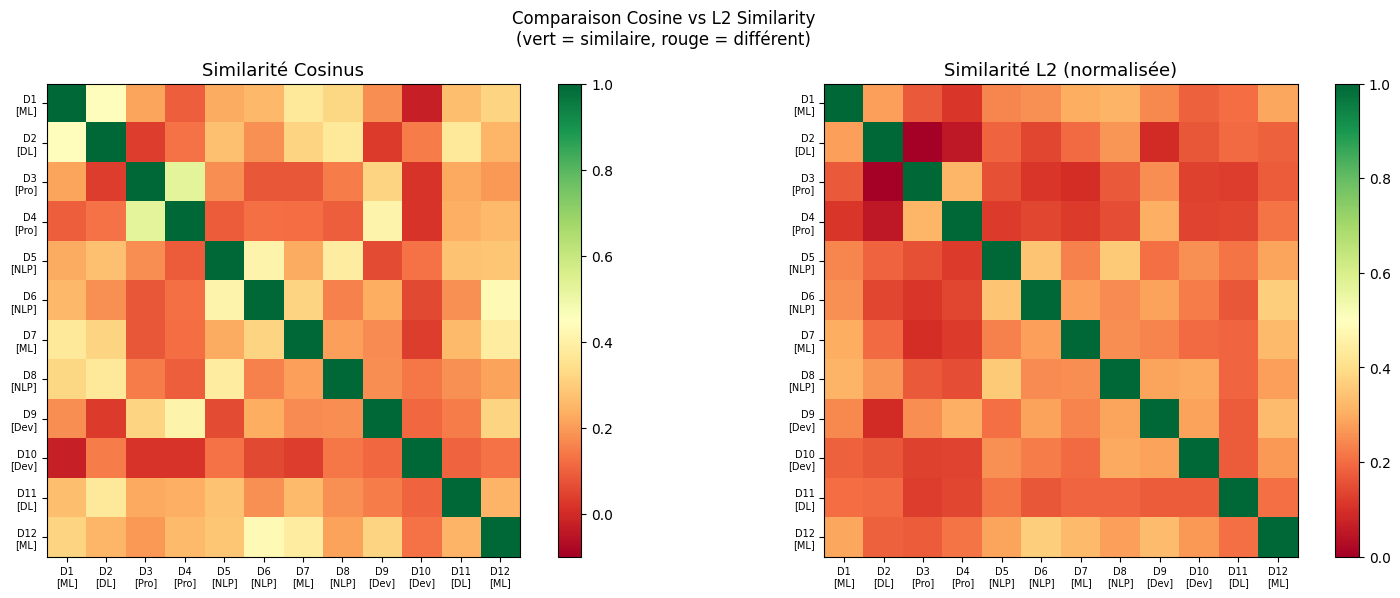

💡 Les deux heatmaps montrent des patterns similaires sur des vecteurs quasi-normalisés.
   Des différences apparaissent sur des embeddings non normalisés (ex: Word2Vec brut).


In [10]:
# Heatmap des métriques normalisées pour tous les documents (12 premiers)
n_docs = 12
subset = embeddings[:n_docs]

# Calcul de toutes les métriques pour la heatmap
from sklearn.preprocessing import normalize

# Cosine (sur vecteurs normalisés = produit scalaire)
normalized = normalize(subset)
cosine_mat = normalized @ normalized.T

# L2 distances
from sklearn.metrics import pairwise_distances
l2_mat = pairwise_distances(subset, metric='euclidean')
# Convertir en similarité (0=similaire) → normalisé entre 0 et 1
l2_sim = 1 - (l2_mat / l2_mat.max())

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
categories = df['category'].values[:n_docs]
doc_labels = [f"D{i+1}\n[{c[:3]}]" for i, c in enumerate(categories)]

# Cosine heatmap
im1 = axes[0].imshow(cosine_mat, cmap='RdYlGn', vmin=-0.1, vmax=1.0)
axes[0].set_title('Similarité Cosinus', fontsize=13)
axes[0].set_xticks(range(n_docs))
axes[0].set_yticks(range(n_docs))
axes[0].set_xticklabels(doc_labels, fontsize=7)
axes[0].set_yticklabels(doc_labels, fontsize=7)
plt.colorbar(im1, ax=axes[0])

# L2 heatmap (normalisée en similarité)
im2 = axes[1].imshow(l2_sim, cmap='RdYlGn', vmin=0.0, vmax=1.0)
axes[1].set_title('Similarité L2 (normalisée)', fontsize=13)
axes[1].set_xticks(range(n_docs))
axes[1].set_yticks(range(n_docs))
axes[1].set_xticklabels(doc_labels, fontsize=7)
axes[1].set_yticklabels(doc_labels, fontsize=7)
plt.colorbar(im2, ax=axes[1])

plt.suptitle('Comparaison Cosine vs L2 Similarity\n(vert = similaire, rouge = différent)',
             fontsize=12)
plt.tight_layout()
plt.show()

print("💡 Les deux heatmaps montrent des patterns similaires sur des vecteurs quasi-normalisés.")
print("   Des différences apparaissent sur des embeddings non normalisés (ex: Word2Vec brut).")

---
# 🔬 Section 5 — FAISS : Théorie Approfondie

## Qu'est-ce que FAISS ?

**FAISS** (Facebook AI Similarity Search) est une bibliothèque open source développée par **Meta AI Research** en 2017. Elle fournit des algorithmes efficaces pour la **recherche de similarité** dans de grandes collections de vecteurs denses.

### Caractéristiques clés
- 🚀 Optimisée pour les GPU (et CPU)
- 📦 Implémentée en C++ avec une interface Python
- 🎯 Supporte des milliards de vecteurs
- 🛠️ Multiples types d'index selon les besoins
- 📊 Métriques : L2 (euclidienne) et Inner Product

---

## Les Principes de l'ANN (Approximate Nearest Neighbor)

Le problème fondamental : étant donné N vecteurs de dimension D et une requête q, trouver les k vecteurs les plus proches.

**Approche naïve (Brute Force)** : comparer q avec tous les N vecteurs → $O(N \cdot D)$ opérations.

Pour N=10M, D=768 : **7.68 milliards** d'opérations par requête → trop lent !

Les algorithmes ANN utilisent des **structures de données pré-construites** pour réduire le nombre de comparaisons nécessaires, au prix d'une légère perte de précision.

---

## Les 4 Grands Types d'Index FAISS

---

### 📦 1. IndexFlatL2 / IndexFlatIP — Recherche Exacte par Force Brute

#### Principe
C'est le plus simple : **comparer la requête avec TOUS les vecteurs** stockés, sans aucune optimisation. FAISS utilise néanmoins du SIMD (SSE/AVX) pour vectoriser les calculs et les GPU si disponibles.

#### Algorithme
```
Pour chaque requête q:
    Pour chaque vecteur v_i dans l'index:
        Calculer d(q, v_i)
    Retourner les k vecteurs avec la plus petite distance
```

#### Caractéristiques
| Attribut | Valeur |
|----------|--------|
| Complexité | $O(N \cdot D)$ |
| Précision | **100% exact** |
| Entraînement | Non requis |
| Mémoire | $N \cdot D \cdot 4$ bytes (float32) |
| Scalabilité | Jusqu'à ~1M vecteurs (dépend du temps tolérable) |

#### Quand utiliser ?
✅ Datasets < 100K vecteurs  
✅ Quand la précision absolue est requise  
✅ Pour valider d'autres index (benchmark de référence)  
✅ Prototypage rapide  

---

### 🗂️ 2. IndexIVFFlat — Inverted File Index

#### Principe

L'idée vient de l'**index inversé** en recherche d'information (comme dans un moteur de recherche), adapté à la géométrie vectorielle.

**Étape d'entraînement :** Appliquer k-means sur les N vecteurs pour créer `nlist` **centroides** (cellules de Voronoï). Chaque vecteur est assigné à son centroïde le plus proche.

**Étape de recherche :** Au lieu de parcourir tous les N vecteurs :
1. Trouver les `nprobe` cellules de Voronoï les plus proches de la requête
2. Chercher uniquement dans ces cellules
3. Retourner les k meilleurs vecteurs trouvés

#### Visualisation des cellules de Voronoï

```
Espace vectoriel 2D
┌─────────────────────────────┐
│  ×   ×  │  ×   × │ ×       │
│    ★₁   │   ★₂   │  ★₃    │
│ ×  × × │× ×  × │   ×  ×  │
├────────────────────────────-│
│     ×   │   ×  ×│  ×  ×   │
│   ★₄    │   ★₅  │   ★₆   │
│× ×  ×   │ ×   × │×   ×  × │
└─────────────────────────────┘
★ = centroïde,  × = vecteur,  │ = frontière Voronoï

Pour une requête q proche de ★₂:
→ Chercher uniquement dans les cellules de ★₂ (et ★₁,★₃ si nprobe=3)
→ Éviter de chercher dans ★₄,★₅,★₆
```

#### Hyperparamètres clés

| Paramètre | Rôle | Valeur typique |
|-----------|------|----------------|
| `nlist` | Nombre de cellules Voronoï | $\sqrt{N}$ à $4\sqrt{N}$ |
| `nprobe` | Cellules explorées à la requête | 1-64 (plus = plus précis, plus lent) |

#### Règle empirique FAISS
- Entraînement : il faut **au moins 39 × nlist** vecteurs (idéalement 256 × nlist)
- Pour N=1M : nlist=1000, nprobe=10-50 est un bon point de départ

#### Quand utiliser ?
✅ Datasets 100K à 10M vecteurs  
✅ Bon compromis vitesse/précision  
✅ Quand les données sont disponibles pour l'entraînement  

---

### 🗜️ 3. IndexIVFPQ — IVF + Product Quantization

#### Principe

Combine l'IVF avec la **quantification par produit (PQ)** pour une **compression massive** des vecteurs.

**Product Quantization :**
1. Diviser le vecteur de dimension D en `M` sous-vecteurs de dimension D/M
2. Pour chaque sous-espace : apprendre un codebook de `ksub` centroides via k-means
3. Encoder chaque vecteur comme M indices de centroïdes → vecteur de M octets !

$$\vec{v} \in \mathbb{R}^D \rightarrow (c_1, c_2, ..., c_M) \in \{0,...,255\}^M$$

**Exemple de compression :**
- Vecteur original : 768 dims × 4 bytes = **3072 bytes**
- Après PQ (M=96, ksub=256) : 96 × 1 byte = **96 bytes** → compression **32×** !

#### Visualisation de PQ

```
Vecteur original 768-dim:
[v₁, v₂, ..., v₁₂₈ | v₁₂₉, ..., v₂₅₆ | ... | v₆₄₁, ..., v₇₆₈]
     sous-vecteur 1       sous-vecteur 2         sous-vecteur 6

Après PQ :
[c₁ | c₂ | c₃ | c₄ | c₅ | c₆]  (6 codes d'un octet chacun)
 ↑ index centroïde dans codebook M₁
```

#### Hyperparamètres

| Paramètre | Rôle | Valeur typique |
|-----------|------|----------------|
| `M` | Nombre de sous-vecteurs | 8, 16, 32, 64, 96 |
| `nbits` | Bits par code (ksub=2^nbits) | 8 (256 centroides par sous-espace) |
| `nlist` | Cellules IVF | $\sqrt{N}$ |

#### Quand utiliser ?
✅ Datasets > 10M vecteurs  
✅ Contraintes mémoire strictes  
✅ Trade-off mémoire/précision accepté  
⚠️ Rappel inférieur à IVFFlat (typiquement 90-98%)  

---

### 🕸️ 4. IndexHNSWFlat — Hierarchical Navigable Small World

#### Principe

HNSW est basé sur les **graphes "petit monde"** (small world graphs). L'idée vient du phénomène des "six degrés de séparation" : dans un réseau social, n'importe qui peut être rejoint en quelques étapes.

**Construction :**
1. Chaque vecteur devient un nœud dans un graphe multi-couches
2. Les connexions (arêtes) sont créées vers les voisins proches
3. Les couches supérieures = liens "longue distance" (navigation rapide)
4. Les couches inférieures = liens "courte distance" (précision fine)

**Recherche :**
1. Entrer par le haut (longue portée) et descendre vers la requête
2. Greedy search : toujours aller vers le nœud le plus proche de q
3. Affiner au niveau le plus bas

#### Structure en couches

```
Couche 2 (peu de nœuds, liens longue distance):
    A ────────────── F
    
Couche 1 (plus de nœuds):
    A ──── C ──── F
           |
           D
           
Couche 0 (tous les nœuds, liens locaux):
    A ─ B ─ C ─ D ─ E ─ F
    
Requête q proche de E:
→ Entrer en A (couche 2), aller vers F (plus proche de q)
→ Descendre en couche 1: F→D (plus proche de q)
→ Couche 0: D→E (solution!)
```

#### Hyperparamètres

| Paramètre | Rôle | Valeur typique |
|-----------|------|----------------|
| `M` | Connexions par nœud | 16-64 (plus = meilleur recall, plus de mémoire) |
| `efConstruction` | Qualité de construction | 40-200 (plus = meilleur index, plus lent à construire) |
| `efSearch` | Qualité de recherche | 16-512 (plus = meilleur recall, plus lent) |

#### Quand utiliser HNSW ?
✅ Requêtes très basses latences requises  
✅ Bon recall sans trop de tuning  
✅ Données < 10M vecteurs (mémoire)  
⚠️ **Consommation mémoire élevée** : N × M × 4 bytes pour les graphes  
⚠️ Construction plus lente que IVF  

---

## Tableau Comparatif Complet des Index FAISS

| Index | Exact | Entraînement | Mémoire | Build Time | Search Time | Recall | Cas d'usage |
|-------|-------|-------------|---------|------------|-------------|--------|-------------|
| **IndexFlatL2** | ✅ 100% | Non | $N \times D \times 4$ bytes | Immédiat | $O(N\cdot D)$ | 100% | <100K vecteurs, précision absolue |
| **IndexFlatIP** | ✅ 100% | Non | $N \times D \times 4$ bytes | Immédiat | $O(N\cdot D)$ | 100% | Comme Flat L2, cosine search |
| **IndexIVFFlat** | ❌ ANN | Oui (k-means) | $N \times D \times 4$ bytes | Moyen | $O(nprobe \times N/nlist \times D)$ | 95-99% | 100K-10M vecteurs |
| **IndexIVFPQ** | ❌ ANN | Oui (k-means + PQ) | $N \times M$ bytes | Long | Très rapide | 90-98% | >10M vecteurs, contrainte mémoire |
| **IndexHNSWFlat** | ❌ ANN | Non (graph) | $N \times D \times 4 + graph$ | Long | $O(\log N)$ | 97-99% | Basse latence, <10M vecteurs |

---

## Guide de Sélection d'Index FAISS

```
Combien de vecteurs ?
│
├─ < 100K ──────────────────→ IndexFlatL2 (exact, simple)
│
├─ 100K à 1M ───────────────→ IndexIVFFlat (bon compromis)
│                              nlist = sqrt(N), nprobe = 10-50
│
├─ 1M à 10M
│   ├─ Mémoire OK ──────────→ IndexHNSWFlat (basse latence)
│   └─ Mémoire limitée ─────→ IndexIVFFlat ou IndexIVFPQ
│
└─ > 10M ───────────────────→ IndexIVFPQ (compression requise)
                               ou moteur dédié (Milvus, Qdrant)
```

## 5. FAISS: Index de Recherche Vectorielle

### 5.1 Index Flat (Brute Force)

In [11]:
def create_faiss_index_flat(embeddings: np.ndarray) -> faiss.IndexFlatL2:
    """
    Créer un index FAISS Flat (recherche exhaustive)
    """
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)  # L2 distance
    index.add(embeddings)  # Ajouter les vecteurs
    return index

# Créer l'index
index_flat = create_faiss_index_flat(embeddings)

print(f"✅ Index Flat créé")
print(f"   - Nombre de vecteurs: {index_flat.ntotal}")
print(f"   - Dimension: {index_flat.d}")

✅ Index Flat créé
   - Nombre de vecteurs: 20
   - Dimension: 384


### 5.2 Recherche de similarité

In [12]:
def search_similar(query: str, index: faiss.Index, model: SentenceTransformer,
                   df: pd.DataFrame, k: int = 5) -> pd.DataFrame:
    """
    Rechercher les k documents les plus similaires à une query
    """
    # Créer l'embedding de la query
    query_embedding = model.encode([query]).astype('float32')

    # Rechercher les k plus proches voisins
    distances, indices = index.search(query_embedding, k)

    # Créer un DataFrame des résultats
    results = []
    for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
        results.append({
            "rank": i + 1,
            "id": df.iloc[idx]['id'],
            "text": df.iloc[idx]['text'],
            "category": df.iloc[idx]['category'],
            "distance": dist,
            "similarity": 1 / (1 + dist)  # Approximation de similarité
        })

    return pd.DataFrame(results)

# Test de recherche
query = "Comment fonctionne le deep learning?"
print(f"🔍 Query: {query}\n")

results = search_similar(query, index_flat, embedding_model, df, k=5)
print("📊 Top 5 résultats:")
print(results[['rank', 'text', 'category', 'similarity']].to_string(index=False))

🔍 Query: Comment fonctionne le deep learning?

📊 Top 5 résultats:
 rank                                                                         text category  similarity
    1 Les réseaux de neurones profonds sont utilisés pour l'apprentissage profond.       DL    0.065305
    2          Le machine learning est une branche de l'intelligence artificielle.       ML    0.051823
    3              Le RAG combine retrieval et génération pour améliorer les LLMs.      NLP    0.043984
    4         Le fine-tuning adapte un modèle pré-entraîné à une tâche spécifique.       ML    0.042195
    5    Les embeddings capturent la sémantique des mots dans un espace vectoriel.      NLP    0.042059


### 5.3 Tests avec différentes queries

In [13]:
test_queries = [
    "Qu'est-ce qu'un transformer?",
    "Comment déployer une application?",
    "Python pour l'analyse de données",
    "Recherche vectorielle et embeddings"
]

for query in test_queries:
    print(f"\n{'='*80}")
    print(f"🔍 Query: {query}")
    print('='*80)

    results = search_similar(query, index_flat, embedding_model, df, k=3)

    for _, row in results.iterrows():
        print(f"{row['rank']}. [{row['category']}] {row['text'][:60]}... (sim: {row['similarity']:.3f})")


🔍 Query: Qu'est-ce qu'un transformer?
1. [NLP] Les transformers révolutionnent le traitement du langage nat... (sim: 0.082)
2. [NLP] BERT est un modèle pré-entraîné basé sur l'architecture tran... (sim: 0.065)
3. [DL] L'attention est le mécanisme clé des architectures transform... (sim: 0.058)

🔍 Query: Comment déployer une application?
1. [DevOps] Docker permet de conteneuriser des applications pour un dépl... (sim: 0.071)
2. [ML] Le fine-tuning adapte un modèle pré-entraîné à une tâche spé... (sim: 0.046)
3. [NLP] Le RAG combine retrieval et génération pour améliorer les LL... (sim: 0.045)

🔍 Query: Python pour l'analyse de données
1. [Programming] Python est un langage de programmation populaire pour la dat... (sim: 0.093)
2. [Programming] Pandas est une bibliothèque Python pour l'analyse de données... (sim: 0.056)
3. [ML] Les bases de données vectorielles stockent et recherchent de... (sim: 0.053)

🔍 Query: Recherche vectorielle et embeddings
1. [ML] Les bases de données vectoriel

## 6. Index IVFPQ (Optimisé pour Large Scale)

### 6.1 Création d'un index IVF (Inverted File)

In [14]:
def create_faiss_index_ivf(embeddings: np.ndarray, nlist: int = 10) -> faiss.IndexIVFFlat:
    """
    Créer un index FAISS IVF (plus rapide pour large scale)

    Args:
        embeddings: Vecteurs à indexer
        nlist: Nombre de clusters (voronoi cells)
    """
    dimension = embeddings.shape[1]

    # Créer le quantizer (index flat pour les centroids)
    quantizer = faiss.IndexFlatL2(dimension)

    # Créer l'index IVF
    index = faiss.IndexIVFFlat(quantizer, dimension, nlist)

    # Entraîner l'index (clustering)
    index.train(embeddings)

    # Ajouter les vecteurs
    index.add(embeddings)

    return index

# Pour notre petit dataset, utilisons nlist=5
index_ivf = create_faiss_index_ivf(embeddings, nlist=5)

print(f"✅ Index IVF créé")
print(f"   - Nombre de vecteurs: {index_ivf.ntotal}")
print(f"   - Nombre de clusters: {index_ivf.nlist}")

✅ Index IVF créé
   - Nombre de vecteurs: 20
   - Nombre de clusters: 5


### 6.2 Comparaison Flat vs IVF

In [15]:
import time

def benchmark_search(query: str, index: faiss.Index, model: SentenceTransformer, k: int = 5):
    """
    Mesurer le temps de recherche
    """
    query_embedding = model.encode([query]).astype('float32')

    start = time.time()
    distances, indices = index.search(query_embedding, k)
    elapsed = time.time() - start

    return elapsed * 1000  # en ms

# Benchmark
query = "Qu'est-ce que le machine learning?"

time_flat = benchmark_search(query, index_flat, embedding_model)
time_ivf = benchmark_search(query, index_ivf, embedding_model)

print(f"⏱️ Temps de recherche:")
print(f"   - Flat (exact): {time_flat:.3f} ms")
print(f"   - IVF (approx): {time_ivf:.3f} ms")
print(f"   - Speedup: {time_flat/time_ivf:.2f}x")
print(f"\n⚠️ Note: Sur de petits datasets, Flat peut être plus rapide.")
print(f"   IVF devient intéressant à partir de 10k-100k+ vecteurs.")

⏱️ Temps de recherche:
   - Flat (exact): 0.023 ms
   - IVF (approx): 0.044 ms
   - Speedup: 0.52x

⚠️ Note: Sur de petits datasets, Flat peut être plus rapide.
   IVF devient intéressant à partir de 10k-100k+ vecteurs.


## 7. Évaluation: Recall et Precision

### 7.1 Création d'un ground truth

In [16]:
# Définir des queries avec leurs documents pertinents attendus (ground truth)
ground_truth = [
    {
        "query": "Qu'est-ce qu'un transformer?",
        "relevant_ids": [5, 6, 15]  # Docs sur transformers, BERT, attention
    },
    {
        "query": "Comment utiliser Python?",
        "relevant_ids": [3, 4, 16]  # Docs sur Python, FastAPI, Pandas
    },
    {
        "query": "Machine learning et optimisation",
        "relevant_ids": [1, 7, 12]  # Docs sur ML, gradient descent, fine-tuning
    },
    {
        "query": "Recherche vectorielle",
        "relevant_ids": [8, 18, 19]  # Docs sur embeddings, FAISS, vector DB
    },
]

print("✅ Ground truth défini pour l'évaluation")

✅ Ground truth défini pour l'évaluation


### 7.2 Calcul de Recall@k et Precision@k

In [17]:
def evaluate_retrieval(query: str, relevant_ids: List[int], index: faiss.Index,
                      model: SentenceTransformer, df: pd.DataFrame, k: int = 5):
    """
    Calculer Recall@k et Precision@k
    """
    # Récupérer les résultats
    query_embedding = model.encode([query]).astype('float32')
    _, indices = index.search(query_embedding, k)

    # IDs récupérés
    retrieved_ids = [df.iloc[idx]['id'] for idx in indices[0]]

    # Calculer les métriques
    relevant_retrieved = set(relevant_ids) & set(retrieved_ids)

    recall = len(relevant_retrieved) / len(relevant_ids) if relevant_ids else 0
    precision = len(relevant_retrieved) / k

    return {
        "query": query,
        "k": k,
        "relevant_ids": relevant_ids,
        "retrieved_ids": retrieved_ids,
        "relevant_retrieved": list(relevant_retrieved),
        "recall": recall,
        "precision": precision
    }

# Évaluer toutes les queries
evaluation_results = []

for item in ground_truth:
    result = evaluate_retrieval(
        query=item["query"],
        relevant_ids=item["relevant_ids"],
        index=index_flat,
        model=embedding_model,
        df=df,
        k=5
    )
    evaluation_results.append(result)

    print(f"\n🔍 Query: {result['query']}")
    print(f"   Relevant: {result['relevant_ids']}")
    print(f"   Retrieved: {result['retrieved_ids']}")
    print(f"   ✅ Found: {result['relevant_retrieved']}")
    print(f"   📊 Recall@{result['k']}: {result['recall']:.2%}")
    print(f"   📊 Precision@{result['k']}: {result['precision']:.2%}")


🔍 Query: Qu'est-ce qu'un transformer?
   Relevant: [5, 6, 15]
   Retrieved: [np.int64(5), np.int64(6), np.int64(15), np.int64(20), np.int64(12)]
   ✅ Found: [5, 6, 15]
   📊 Recall@5: 100.00%
   📊 Precision@5: 60.00%

🔍 Query: Comment utiliser Python?
   Relevant: [3, 4, 16]
   Retrieved: [np.int64(3), np.int64(4), np.int64(9), np.int64(16), np.int64(18)]
   ✅ Found: [16, 3, 4]
   📊 Recall@5: 100.00%
   📊 Precision@5: 60.00%

🔍 Query: Machine learning et optimisation
   Relevant: [1, 7, 12]
   Retrieved: [np.int64(1), np.int64(7), np.int64(12), np.int64(17), np.int64(19)]
   ✅ Found: [1, 12, 7]
   📊 Recall@5: 100.00%
   📊 Precision@5: 60.00%

🔍 Query: Recherche vectorielle
   Relevant: [8, 18, 19]
   Retrieved: [np.int64(18), np.int64(19), np.int64(8), np.int64(17), np.int64(20)]
   ✅ Found: [8, 18, 19]
   📊 Recall@5: 100.00%
   📊 Precision@5: 60.00%


### 7.3 Métriques moyennes


📊 MÉTRIQUES MOYENNES
Recall@5:    100.00%
Precision@5: 60.00%


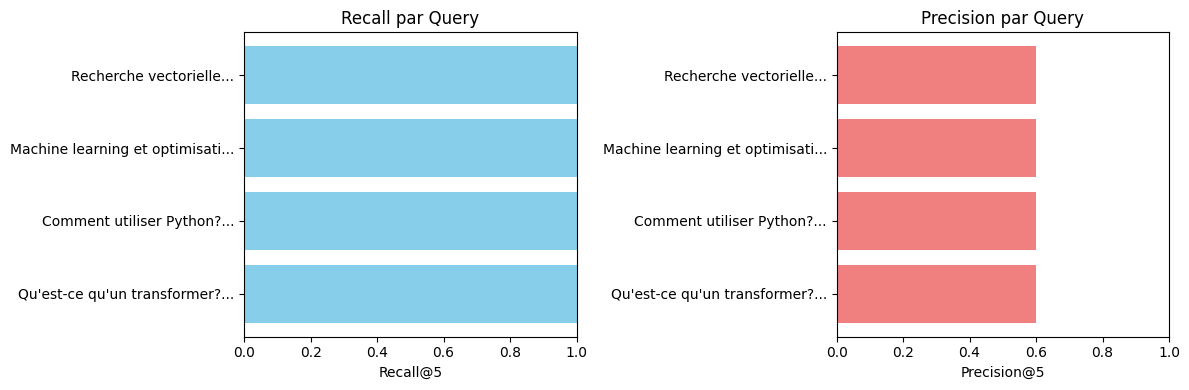

In [18]:
avg_recall = np.mean([r['recall'] for r in evaluation_results])
avg_precision = np.mean([r['precision'] for r in evaluation_results])

print(f"\n{'='*80}")
print(f"📊 MÉTRIQUES MOYENNES")
print(f"{'='*80}")
print(f"Recall@5:    {avg_recall:.2%}")
print(f"Precision@5: {avg_precision:.2%}")

# Visualisation
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

queries = [r['query'][:30] + '...' for r in evaluation_results]
recalls = [r['recall'] for r in evaluation_results]
precisions = [r['precision'] for r in evaluation_results]

ax[0].barh(queries, recalls, color='skyblue')
ax[0].set_xlabel('Recall@5')
ax[0].set_title('Recall par Query')
ax[0].set_xlim(0, 1)

ax[1].barh(queries, precisions, color='lightcoral')
ax[1].set_xlabel('Precision@5')
ax[1].set_title('Precision par Query')
ax[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()

## 8. Sauvegarde et Chargement de l'Index

### 8.1 Sauvegarde

In [19]:
def save_index(index: faiss.Index, embeddings: np.ndarray, df: pd.DataFrame,
               index_path: str = "faiss_index.bin",
               data_path: str = "documents.pkl"):
    """
    Sauvegarder l'index FAISS et les données associées
    """
    # Sauvegarder l'index FAISS
    faiss.write_index(index, index_path)

    # Sauvegarder les données (documents + embeddings)
    data = {
        "documents": df,
        "embeddings": embeddings
    }
    with open(data_path, 'wb') as f:
        pickle.dump(data, f)

    print(f"✅ Index sauvegardé: {index_path}")
    print(f"✅ Données sauvegardées: {data_path}")

# Sauvegarder
save_index(index_flat, embeddings, df)

✅ Index sauvegardé: faiss_index.bin
✅ Données sauvegardées: documents.pkl


### 8.2 Chargement

In [20]:
def load_index(index_path: str = "faiss_index.bin",
               data_path: str = "documents.pkl"):
    """
    Charger l'index FAISS et les données associées
    """
    # Charger l'index
    index = faiss.read_index(index_path)

    # Charger les données
    with open(data_path, 'rb') as f:
        data = pickle.load(f)

    print(f"✅ Index chargé: {index.ntotal} vecteurs")
    print(f"✅ Données chargées: {len(data['documents'])} documents")

    return index, data['documents'], data['embeddings']

# Test de chargement
loaded_index, loaded_df, loaded_embeddings = load_index()

# Vérifier que ça fonctionne
test_query = "Qu'est-ce que l'IA?"
test_results = search_similar(test_query, loaded_index, embedding_model, loaded_df, k=3)
print(f"\n🔍 Test query: {test_query}")
print(test_results[['rank', 'text']].to_string(index=False))

✅ Index chargé: 20 vecteurs
✅ Données chargées: 20 documents

🔍 Test query: Qu'est-ce que l'IA?
 rank                                                                    text
    1     Le machine learning est une branche de l'intelligence artificielle.
    2 FAISS est une bibliothèque pour la recherche de similarité vectorielle.
    3    BERT est un modèle pré-entraîné basé sur l'architecture transformer.


## 9. Exercices Pratiques

### Exercice 1: Ajouter de nouveaux documents
1. Créer 10 nouveaux documents
2. Générer leurs embeddings
3. Les ajouter à l'index existant
4. Tester la recherche

### Exercice 2: Optimiser les hyperparamètres
1. Tester différentes valeurs de `nlist` pour IVF
2. Mesurer l'impact sur la vitesse et le recall
3. Trouver le meilleur compromis

### Exercice 3: Implémenter un filtre de métadonnées
1. Modifier `search_similar` pour filtrer par catégorie
2. Exemple: "Chercher uniquement dans les docs NLP"
3. Comparer les résultats avec/sans filtre

### Exercice 4: Évaluation avancée
1. Implémenter Mean Reciprocal Rank (MRR)
2. Calculer NDCG@k
3. Comparer Flat vs IVF sur ces métriques

## 10. Concepts Avancés

### 10.1 Types d'index FAISS

| Type | Description | Usage |
|------|-------------|-------|
| **Flat** | Brute force, exact | < 10K vecteurs, besoin de précision maximale |
| **IVF** | Inverted file, approximatif | 10K - 10M vecteurs |
| **IVFPQ** | IVF + Product Quantization | 10M+ vecteurs, compression |
| **HNSW** | Hierarchical NSW graph | Très rapide, mémoire élevée |

### 10.2 Métriques de distance
- **L2 (Euclidean)**: Distance euclidienne classique
- **Inner Product**: Produit scalaire (pour vecteurs normalisés = cosine)
- **Cosine**: Angle entre vecteurs

### 10.3 Librairies alternatives
- **Milvus**: Vector DB distribuée, production-ready
- **Weaviate**: Vector DB avec GraphQL
- **Pinecone**: Vector DB managée (cloud)
- **Qdrant**: Vector DB en Rust, performante

---
# 🧭 Section 11 — Guide de Décision Global

## 11.1 Choisir le Bon Modèle d'Embedding

```
Quel type de données ?
│
├─ Texte français/multilingue ─────→ paraphrase-multilingual-MiniLM-L12-v2
│                                     ou multilingual-e5-large
│
├─ Texte anglais haute qualité ────→ sentence-t5-xxl, E5-large-v2
│                                     ou text-embedding-3-large (OpenAI)
│
├─ Texte anglais efficace ─────────→ all-MiniLM-L6-v2 (rapide, 384 dims)
│                                     ou text-embedding-3-small (OpenAI)
│
├─ Images ─────────────────────────→ CLIP (ViT-L/14), DINOv2
│
├─ Images + Texte ─────────────────→ CLIP (même espace vectoriel !)
│
└─ Domaine spécifique ─────────────→ Fine-tuner un modèle général
   (médical, juridique, code...)       sur vos données
```

---

## 11.2 Choisir la Bonne Métrique de Similarité

| Situation | Métrique recommandée | Raison |
|-----------|---------------------|--------|
| Sentence-BERT, paraphrase models | **Cosine** | Entraîné pour cosine |
| OpenAI embeddings | **Cosine** ou **IP** | Vecteurs normalisés |
| Word2Vec raw | **Cosine** | Magnitude non significative |
| Embeddings binaires | **Hamming** | Comparaison bit-à-bit |
| Systèmes de recommandation | **Inner Product** | Magnitude = popularité |
| Images features | **L2** | Distance euclidienne naturelle |
| Documents bag-of-words | **Jaccard** ou **Cosine** | Similarité d'ensembles |

---

## 11.3 Choisir le Bon Index FAISS

| Taille dataset | Contrainte mémoire | Priorité | Index recommandé |
|---------------|-------------------|----------|------------------|
| < 10K | Quelconque | Précision | **IndexFlatL2** |
| 10K - 500K | Mémoire suffisante | Équilibre | **IndexIVFFlat** (nlist=√N) |
| 500K - 5M | Mémoire suffisante | Vitesse | **IndexHNSWFlat** (M=32) |
| 500K - 5M | Mémoire limitée | Compression | **IndexIVFPQ** |
| > 5M | Quelconque | Scalabilité | **Milvus / Qdrant** |

---

## 11.4 Choisir le Bon Moteur Vectoriel

| Critère | Meilleur choix |
|---------|----------------|
| Prototypage rapide | FAISS (local) ou Chroma |
| Production simple | Qdrant (Docker) |
| Grande échelle (>100M) | Milvus |
| Recherche hybride (texte + vecteurs) | Weaviate ou Elasticsearch |
| Zéro maintenance infra | Pinecone (cloud) |
| Déjà sur PostgreSQL | pgvector |
| Temps réel (<10ms) | Redis Vector Search |

---

## 11.5 Tableau de Bord Récapitulatif Complet

| Composant | Choix Budget | Choix Standard | Choix Premium |
|-----------|-------------|----------------|---------------|
| **Modèle embedding** | all-MiniLM-L6-v2 (384d) | paraphrase-multilingual (384d) | text-embedding-3-large (3072d) |
| **Index** | IndexFlatL2 | IndexIVFFlat | IndexHNSWFlat |
| **Moteur** | FAISS local | Qdrant | Pinecone / Milvus |
| **Métrique** | Cosine | Cosine | Cosine / IP |
| **Coût** | 0€ | 0€ (self-hosted) | Variable |
| **Nb vecteurs** | <100K | <10M | Illimité |
| **Latence** | ~10ms | ~5ms | <1ms |

---

## 11.6 Anti-patterns à Éviter

| ❌ Erreur fréquente | ✅ Bonne pratique |
|--------------------|-----------------|
| Utiliser un modèle différent pour indexation et requête | Toujours le **même modèle** dans tout le pipeline |
| Indexer les documents sans chunking | Découper les documents longs (512 tokens max) |
| Ignorer la normalisation des vecteurs | Normaliser quand le modèle l'attend |
| Utiliser L2 sans normaliser pour de l'embedding texte | Utiliser Cosine pour du texte |
| Fixer nprobe=1 pour IVF | Tester nprobe=10-50 selon le recall cible |
| Ne jamais évaluer le recall | Toujours mesurer Recall@k et Precision@k |
| Réindexer à chaque mise à jour unitaire | Batch updates ou incremental indexing |

---

## 11.7 Métriques d'Évaluation Complètes

| Métrique | Formule | Ce qu'elle mesure | Idéal pour |
|----------|---------|-------------------|-----------|
| **Recall@k** | $\frac{|Pertinents \cap Top_k|}{|Pertinents|}$ | % de pertinents retrouvés | RAG, recherche exhaustive |
| **Precision@k** | $\frac{|Pertinents \cap Top_k|}{k}$ | Qualité du top-k | Quand l'utilisateur voit peu de résultats |
| **MRR** | $\frac{1}{N}\sum\frac{1}{rank_1}$ | Position du 1er pertinent | Q&A, moteurs de recherche |
| **NDCG@k** | $\frac{DCG@k}{IDCG@k}$ | Qualité ordonnée des résultats | Ranking, moteurs de recherche |
| **Hit Rate@k** | $\frac{|Queries_{recall>0}|}{|Queries|}$ | % de requêtes avec au moins 1 résultat | Couverture du système |
| **MAP** | Moyenne de AP sur toutes les queries | Qualité globale du système | Évaluation complète |

---
## 📚 Ressources

### Documentation Officielle
- [FAISS Documentation](https://github.com/facebookresearch/faiss/wiki)
- [Sentence Transformers](https://www.sbert.net/)
- [Understanding Vector Search](https://www.pinecone.io/learn/vector-search/)
- [Embeddings Guide OpenAI](https://platform.openai.com/docs/guides/embeddings)

### Moteurs Vectoriels
- [Qdrant Documentation](https://qdrant.tech/documentation/)
- [Milvus Documentation](https://milvus.io/docs)
- [Weaviate Documentation](https://weaviate.io/developers/weaviate)
- [Chroma Documentation](https://docs.trychroma.com/)
- [pgvector GitHub](https://github.com/pgvector/pgvector)

### Articles et Tutoriels
- [ANN Benchmarks](https://ann-benchmarks.com/) — Comparaison des algorithmes ANN
- [The Illustrated Word2Vec](https://jalammar.github.io/illustrated-word2vec/)
- [HNSW Paper (Malkov & Yashunin, 2018)](https://arxiv.org/abs/1603.09320)
- [Product Quantization (Jégou et al., 2011)](https://inria.hal.science/inria-00514462v2/document)

## ✅ Checklist

- [ ] Comprendre ce qu'est un embedding et comment il est créé
- [ ] Connaître les différents types de modèles d'embeddings
- [ ] Comprendre la recherche vectorielle vs recherche par mots-clés
- [ ] Maîtriser les métriques : Cosine, L2, Inner Product, L1
- [ ] Comprendre les 4 types d'index FAISS (Flat, IVF, IVFPQ, HNSW)
- [ ] Savoir choisir le bon moteur vectoriel selon le contexte
- [ ] Embeddings créés pour tous les documents
- [ ] Index FAISS Flat implémenté et testé
- [ ] Index FAISS IVF implémenté et testé
- [ ] Démonstration comparative des métriques de distance
- [ ] Recall et Precision calculés
- [ ] Index sauvegardé localement
- [ ] Benchmark de performance effectué

---

**Session S10 complétée! 🚀**

*Prochaine étape : S11 — RAG (Retrieval-Augmented Generation) — combiner embeddings + LLM pour des réponses basées sur vos données !*